<h1 align='center'> Light Curve Modelling and Physical Parameter Estimation <h1>

## For this section we intend to use the analytical models proposed by Sapir \& Waxman $\href{https://iopscience.iop.org/article/10.3847/1538-4357/aa64df}{2017}$ in order to estimate the physical parameters of ZN-7090

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm

In [2]:
# Load in data from bolometric corrections
data1 = np.load("Layman_B-V.npz")
data2 = np.load("Layman_B-i.npz")
data3 = np.load("Layman_V-i.npz")
# Load interpolated light curves
Bmags, Bmags_err = np.load("Inter_B.npz")['x1'],np.load("Inter_B.npz")['x2']
Vmags, Vmags_err = np.load("Inter_V.npz")['x1'],np.load("Inter_V.npz")['x2']
imags, imags_err = np.load("Inter_i.npz")['x1'],np.load("Inter_i.npz")['x2']

In [3]:
# Create pandas df for corrections
BC_df = pd.DataFrame()

In [4]:
BC_df["Color"] = ['B - V','B - i','V - i']
BC_df["Type"] = ["BC","BC","BC"]
BC_df["Range"] = [[-0.2, 0.5],[-0.392,2.273],[-0.391,0.658]]
BC_df["C0"] = [-0.393,-0.155,0.181]
BC_df["C1"] = [0.786,-0.450,-0.212]
BC_df["C2"] = [-2.124,-0.167,-1.137]
BC_df["RMS"] = [0.089,0.023,0.044]

In [5]:
BC_df

,Color,Type,Range,C0,C1,C2,RMS
0,B - V,BC,"[-0.2, 0.5]",-0.393,0.786,-2.124,0.089
1,B - i,BC,"[-0.392, 2.273]",-0.155,-0.450,-0.167,0.023
2,V - i,BC,"[-0.391, 0.658]",0.181,-0.212,-1.137,0.044


<h1 align='center'> Layman et al. 2014 B-V<h1>

## Apply Color Smoothening Function to all Bolometric corrections

In [6]:
# Collect specific rows numpy file
dates = data1['t']
mbol = data1['m']
mbol_err = data1['merr']
color = data1['c']
color_err = data1['cerr']
correction = data1['cor']
correction_err = data1['corerr']

In [7]:
# Smoothen color evolution through Monte-Carlo fitting
from Helpers import HO_PolyFit
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)

# Define polynomial of degree 6
def poly_6(x,c0,c1,c2,c3,c4,c5,c6):
    return(c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6)

# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute corresponding bolometric correction terms for colors
def BC_pol(x,c0,c1,c2):
    return(c0 + c1*x + c2*x**2)

In [8]:
# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[0]['C0'],\
                       BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

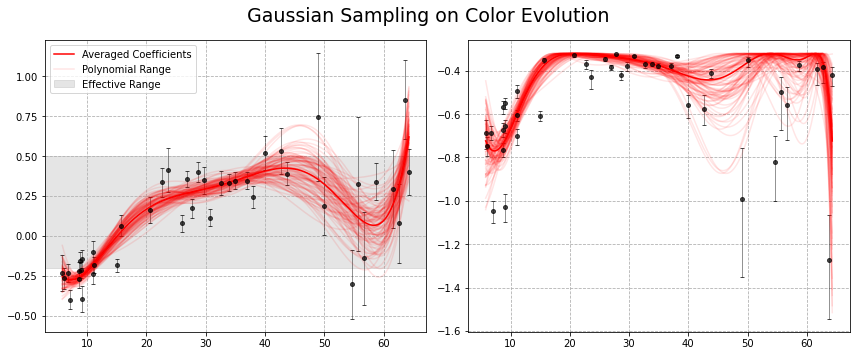

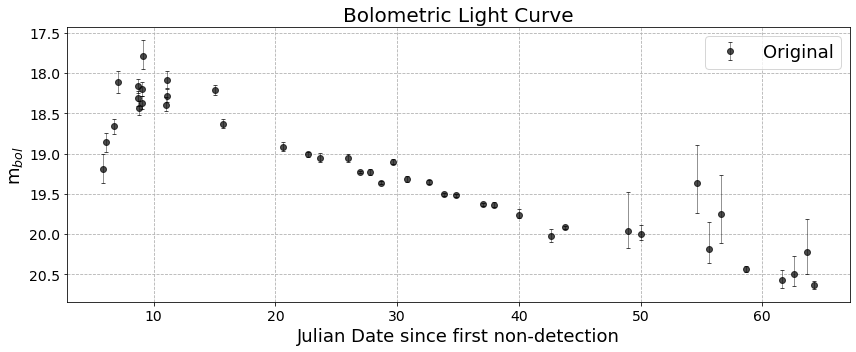

In [9]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),c='r',label="Averaged Coefficients")

a0.axhspan(BC_df.loc[0]['Range'][0], BC_df.loc[0]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
#a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags,\
           #yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Smoothen')
a0.invert_yaxis()
mbol_BV = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian Date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Save corrected bolometric magntiudes and new error bars
BVm = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags
BVm_err = simulated_err

<h1 align='center'> Layman et al. 2016 B-i <h1>

In [11]:
# Collect specific rows numpy file
dates = data2['t']
mbol = data2['m']
mbol_err = data2['merr']
color = data2['c']
color_err = data2['cerr']
correction = data2['cor']
correction_err = data2['corerr']

In [12]:
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)
# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[1]['C0'],\
                       BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

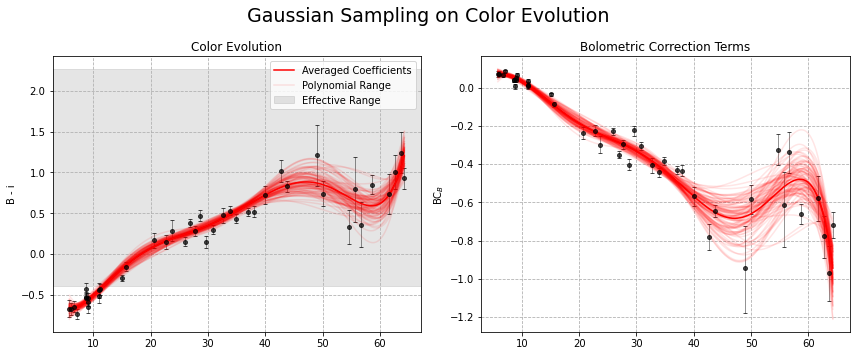

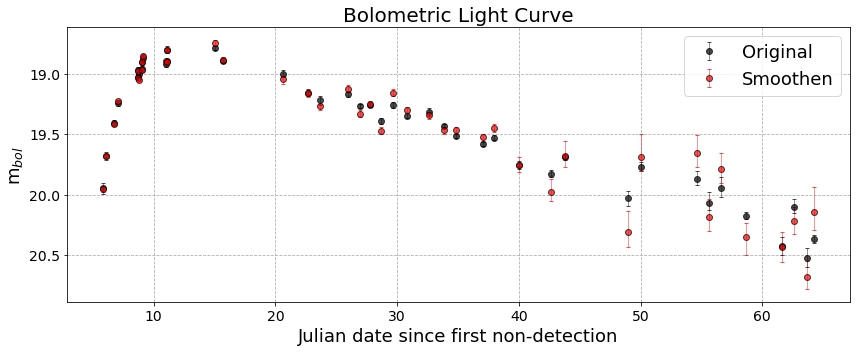

In [13]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),c='r',label="Averaged Coefficients")
a0.set_title("Color Evolution")
a0.set_ylabel("B - i")
a1.set_title("Bolometric Correction Terms")
a1.set_ylabel("BC$_B$")

a0.axhspan(BC_df.loc[1]['Range'][0], BC_df.loc[1]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Smoothen')
a0.invert_yaxis()
mbol_Bi = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
Bim = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags
Bim_err = simulated_err

<h1 align='center'>Layman et al. 2016 V-i <h1>

In [15]:
# Collect specific rows numpy file
dates = data3['t']
mbol = data3['m']
mbol_err = data3['merr']
color = data3['c']
color_err = data3['cerr']
correction = data3['cor']
correction_err = data3['corerr']

In [16]:
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)
# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[2]['C0'],\
                       BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

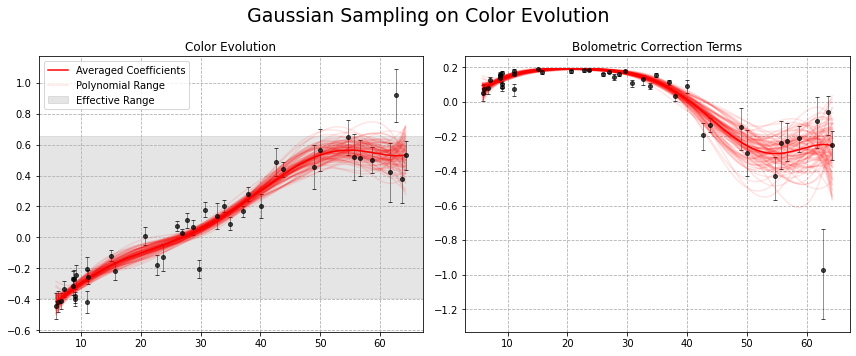

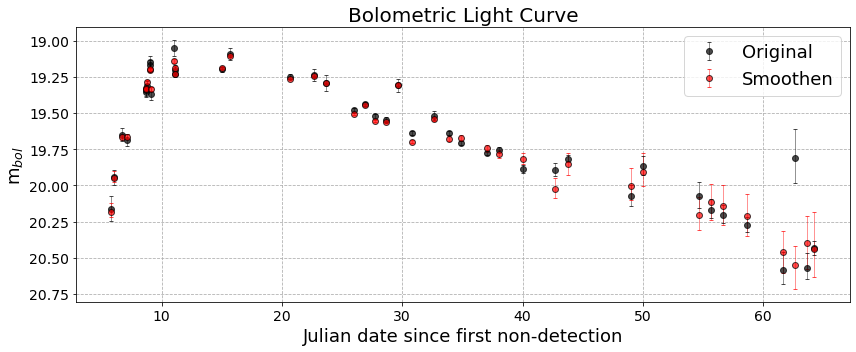

In [17]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),c='r',label="Averaged Coefficients")
a0.set_title("Color Evolution")
a1.set_title("Bolometric Correction Terms")

a0.axhspan(BC_df.loc[2]['Range'][0], BC_df.loc[2]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Smoothen')
a0.invert_yaxis()
mbol_Vi = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
Vim = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags
Vim_err = simulated_err 

<h1 align='center'>Converting to bolometric luminosity using $z=0.1$<h1>

We need to find the comoving distance to the SN which can be found through the following expression

$$
    D_c = \frac{c}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_{M,0}(1+z')^3 + \Omega_{k,0}(1+z')^2 + \Omega_{\Lambda,0}}}
$$

Where the current day accepeted cosmological parameters are

$$
\Omega_{M,0} =  0.27 \\
\Omega_{k,0} = 0.00 \\
\Omega_{\Lambda,0} =  0.73\\
H_0 = 73.24 \, \mathrm{(km \, s^{-1})\, Mpc^{-1}}
$$

Values for $H_0$, $\Omega_{M,0}$ and $\Omega_{\Lambda,0}$ are obtained from Reiss et al. $\href{https://iopscience.iop.org/article/10.3847/0004-637X/826/1/56}{2016}$. While $\Omega_{k,0}$ is calculated through its definition $\Omega_{M,0} + \Omega_{k,0} + \Omega_{\Lambda,0} = 1$ according to Hogg $\href{https://arxiv.org/pdf/astro-ph/9905116v4.pdf}{2020}$

Once we have comoving distance we can compute the luminosity distance as follows

$$
D_L = D_c(1+z)
$$

In [19]:
# Define redshift
z = 0.1

# Define cosmological density parameters
OM = 0.27
OK = 0.00
OL = 0.73

In [20]:
import scipy.integrate as integrate
import astropy.units as u
from astropy.constants import c

# Numerically integrate for the comoving distance at z=0.1
def func(z,M,K,L):
    return(1/np.sqrt(M*(1+z)**3 + K*(1+z)**2 + L))

val = integrate.quad(func,0,z,args=(OM,OK,OL))

# Using H = 67.5 (+/-) 0.5 km/s/Mpc
H = (74.2*u.km/u.s/u.Mpc).to(1/u.s) # 1/s
DC = c/H *val
DL = DC*(1+z)
Dl, Dl_err = DL[0], DL[1]
print("Distance to ZN-7090")
print(Dl.to(u.Mpc),"(+/-)",Dl_err.to(u.Mpc))

Distance to ZN-7090
435.22232959971024 Mpc (+/-) 4.831938511525971e-12 Mpc


## Compute absolute bolometric magnitude for each correction using the calculated value for $D_{L}$ using the following expression

$$
M = m - 5\mathrm{log}_{10}\left(\frac{D_L}{10\, \mathrm{pc}}\right)
$$

From absolute magnitude we can compute the luminosity throug the following relationship 

$$
\frac{L_{bol,*}}{L_{bol,\odot}} = 100^{(M_{bol,\odot} - M_{bol,*})/5}
$$

Where 

$$
L_{bol,\odot} = 3.845 \times 10^{33}\, \mathrm{erg s^{-1}}\\
M_{bol,\odot} = 4.74 
$$

In [21]:
# Convert from apparent bolometric magntiudes to absolute bolometric magnitudes
BVM = BVm - 5*np.log10(Dl.to(u.pc)/(10*u.pc))
BiM = Bim - 5*np.log10(Dl.to(u.pc)/(10*u.pc))
ViM = Vim - 5*np.log10(Dl.to(u.pc)/(10*u.pc))

# Convert from bolometric absolute magnitude to bolometric luminosity
Lsun = 3.845e33 *u.erg/u.s
Msun = 4.74

# Use the bolometric luminosity calculated through the color evoluion fit
BVL = (Lsun*100**((Msun - BVM)/5)).value
BiL = (Lsun*100**((Msun - BiM)/5)).value
ViL = (Lsun*100**((Msun - ViM)/5)).value
BVM

<Quantity [-19.03421953, -19.32448427, -19.61146484, -19.80057351,
           -20.00514085, -19.9423642 , -19.92885489, -20.06059799,
           -19.99353347, -20.10498692, -19.91078325, -20.00474148,
           -19.90014812, -19.76042671, -19.58470728, -19.27385418,
           -19.12955135, -19.00608704, -19.1258881 , -18.90877468,
           -18.97839629, -18.74540926, -19.05014645, -18.89198032,
           -18.82490741, -18.68205242, -18.66882612, -18.57571325,
           -18.635673  , -18.29238424, -18.02405314, -18.30066283,
           -17.58995086, -18.20182399, -18.3130687 , -17.81754119,
           -18.24230012, -17.70905116, -17.50856498, -17.66414418,
           -17.21456494, -17.82822916]>

In [22]:
from Bolometric_Corrections import Layman2Luminosity

Lbol1, Lbol_err1 = Layman2Luminosity(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'],\
                                     BC_df.loc[0]['C1'],BC_df.loc[0]['C2'],z)

Lbol2, Lbol_err2 = Layman2Luminosity(Bmags,imags,Bmags_err,imags_err,BC_df.loc[1]['C0'],\
                                     BC_df.loc[1]['C1'],BC_df.loc[1]['C2'],z)

Lbol3, Lbol_err3 = Layman2Luminosity(Vmags,imags,Vmags_err,imags_err,BC_df.loc[2]['C0'],\
                                     BC_df.loc[2]['C1'],BC_df.loc[2]['C2'],z)

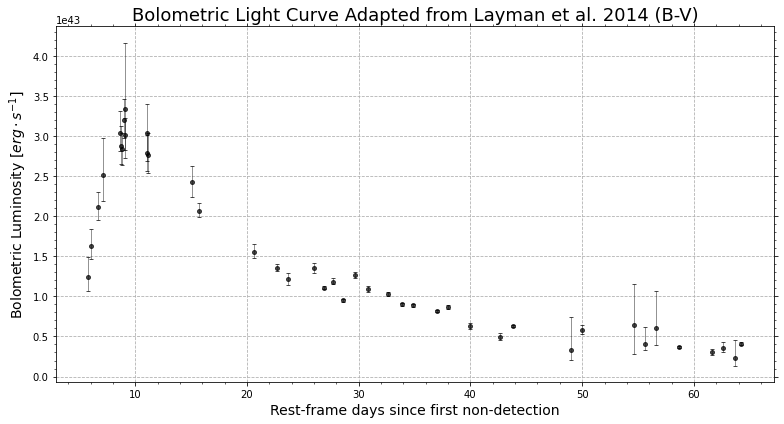

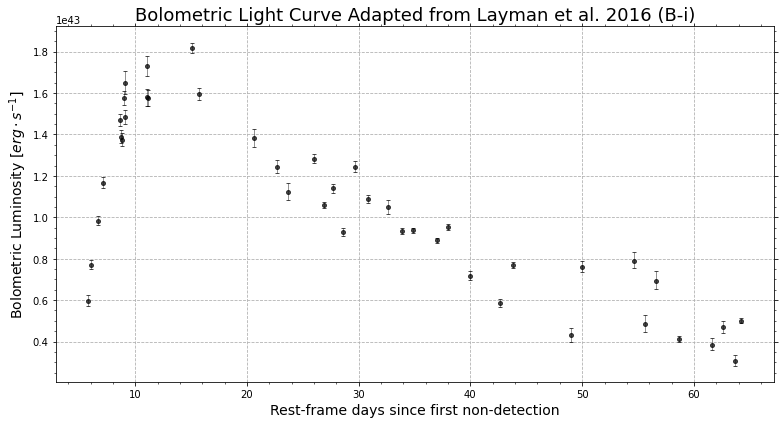

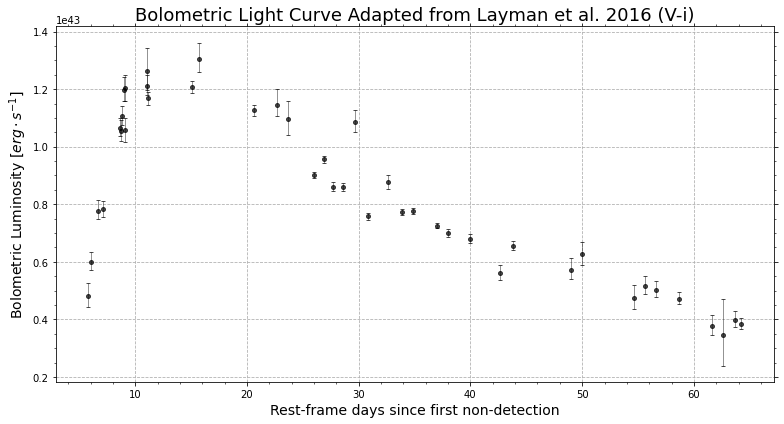

In [23]:
fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
a0.errorbar(dates,BVL,yerr=Lbol_err1,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"Rest-frame days since first non-detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2014 (B-V)",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.1e43))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
a0.errorbar(dates,BiL,yerr=Lbol_err2,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"Rest-frame days since first non-detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2016 (B-i)",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.05e43))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
a0.errorbar(dates,ViL,yerr=Lbol_err3,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"Rest-frame days since first non-detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2016 (V-i)",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.05e43))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

<h1 align='center'> Observe distributions of MC Simulations <h2>

Layman et al. 2014 (B-V)


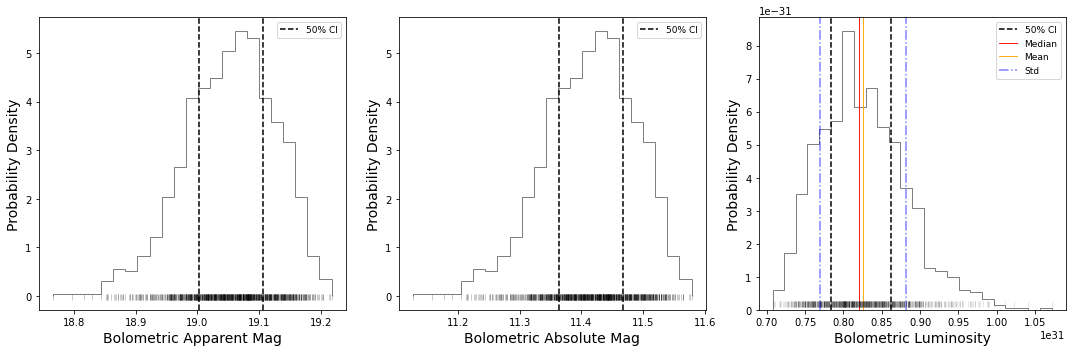

Pearson's Median Skewness of Bolometric Luminosity Distribution
0.2652494651072608
Layman et al. 2016 (B-i)


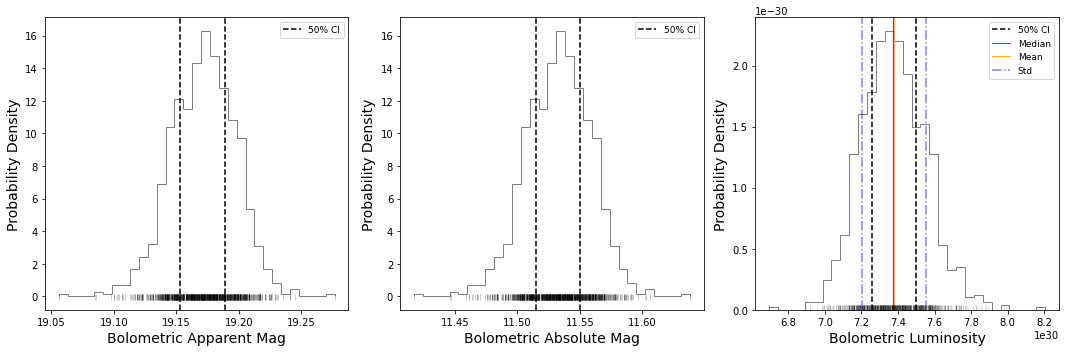

Pearson's Median Skewness of Bolometric Luminosity Distribution
0.11222285776647777
Layman et al. 2016 (V-i)


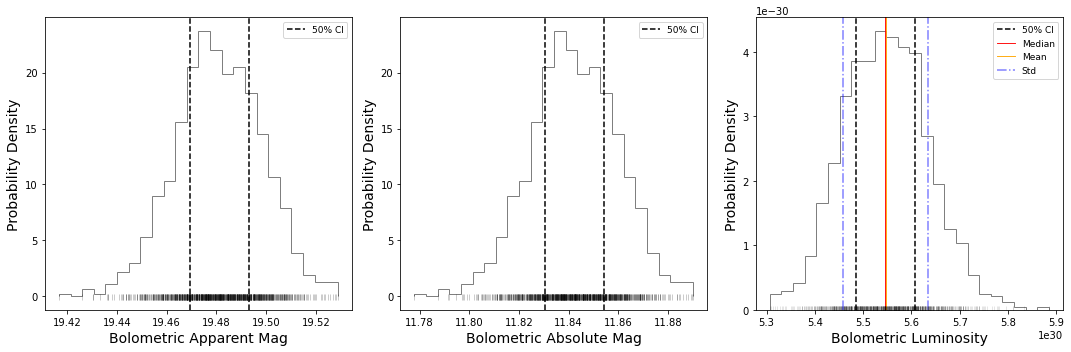

Pearson's Median Skewness of Bolometric Luminosity Distribution
0.043124382684820564


In [24]:
from Helpers import MC_Simulation_Graph,MC_Simulation_Array
sample_i = 18
print("Layman et al. 2014 (B-V)")
MC_Simulation_Graph(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'], BC_df.loc[0]['C1'], BC_df.loc[0]['C2'],(Dl.to(u.pc)).value,\
             sample_i)
print("Layman et al. 2016 (B-i)")
MC_Simulation_Graph(Bmags,imags,Bmags_err,imags_err,BC_df.loc[1]['C0'], BC_df.loc[1]['C1'], BC_df.loc[1]['C2'],(Dl.to(u.pc)).value,\
             sample_i)
print("Layman et al. 2016 (V-i)")
MC_Simulation_Graph(Vmags,imags,Vmags_err,imags_err,BC_df.loc[2]['C0'], BC_df.loc[2]['C1'], BC_df.loc[2]['C2'],(Dl.to(u.pc)).value,\
             sample_i)

Layman 2014 (B-V)


C:\Users\patri\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


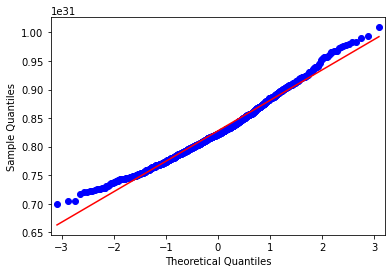

Layman 2016 (B-i)


C:\Users\patri\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


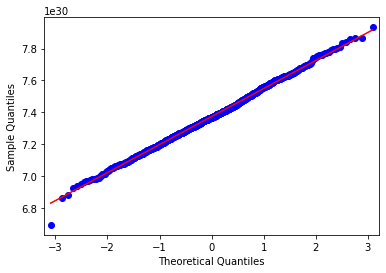

C:\Users\patri\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Layman 2016 (V-i)


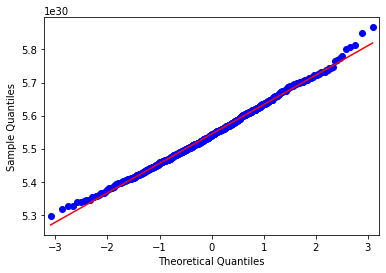

In [25]:

s_BV = MC_Simulation_Array(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'], BC_df.loc[0]['C1'], BC_df.loc[0]['C2'],(Dl.to(u.pc)).value,\
             sample_i)[-1]
s_Bi = MC_Simulation_Array(Bmags,imags,Bmags_err,imags_err,BC_df.loc[1]['C0'], BC_df.loc[1]['C1'], BC_df.loc[1]['C2'],(Dl.to(u.pc)).value,\
             sample_i)[-1]
s_Vi = MC_Simulation_Array(Vmags,imags,Vmags_err,imags_err,BC_df.loc[2]['C0'], BC_df.loc[2]['C1'], BC_df.loc[2]['C2'],(Dl.to(u.pc)).value,\
             sample_i)[-1]
print("Layman 2014 (B-V)")
fig = sm.qqplot(s_BV,line='s')
plt.show()

print("Layman 2016 (B-i)")
fig = sm.qqplot(s_Bi,line='s')
plt.show()

print("Layman 2016 (V-i)")
fig = sm.qqplot(s_Vi,line='s')
plt.show()

From the QQ-Plots and the Pearson Median Skewness factor we conclude that we can safely treat the (B-i) and (V-i) bolometri luminosity distributions as Gaussian distributions.

## Rabinak & Waxman 2011

Implementing simple model for a Hydrogen rich envelope star (RSG) and fitting for physical parameters. We take the bolometric solution corresponding for a polytropic index of $n=3/2$ of the following form.

$$
    L = 8.5 \times 10^{42} \, \frac{E_{51}^{0.92}R_{*,13}}{f_{\rho}^{0.27}(M/M_{\odot})^{0.84}\kappa_{0.34}^{0.92}}t_5^{-0.16} \, \mathrm{erg \, s^{-1}}
$$

According to Rabinak 2011 at early times the dominant source of opacity in a Type II SNe is Thompson scattering, due to the high ionization of the envelope. However, the specific value for this quantity depends on the He mass fraction

$$
\kappa_{es} = 0.2(1+X)\, \mathrm{cm^2\, g^{-1}}
$$

Therefore I will be fitting the for $\kappa$ because I am not sure what to use for the He mass fraction

Additionally, $f_{\rho}$ is a dimensionless quantity that quantifies the density of the ejecta. Calzavara & Matzner have derived the expected values for $f_{\rho}$ for various progenitors from $0.031 < f_{\rho} < 0.062$ for BSG and $0.079 < f_{\rho} < 0.13$ for RSG. Rabinak and Waxman note that their results are not sensitive to the specific values of $f_{\rho}$.

In [26]:
# Define analytic luminosity function
def Rabinak(t5,E51,R13,M,k34,fp):
    
    '''
    Define Rabinak and Waxman bolometric luminosity analytical expression. Where the units are as follows
    E = 10^51 E51 (erg)
    t = 10^5 t5 (s)
    R = 10^13 R13 (cm)
    M = M/Msun 
    k = 0.34 k34 (cm2g-1)
    '''
    
    return(8.5e42*(E51**0.92*R13)/(fp**0.27*M**0.84*k34**0.92)*t5**(-0.16))

The paper states its models describes the evolution of Type II SNe on a range of hour to days from the first elecrtromagnetic emission. However, it does not specify an specific date range to which the model works best for. However they do mention that the focus of their paper is to study the $\sim$ 1 day UV/O emssion following the X-ray burst. So noting this I am thinking of fitting the data post 2 days from the first detection

## Nir Sapir & Waxman 2017

This paper provides an extension for the 2011 model for later times by adding a suppression factor to the luminosity function as follows

$$
\frac{L}{L_{RW}} = A\mathrm{exp}\left[-\left(\frac{at}{t_{tr}}\right)^\alpha\right]
$$

Where $A=0.94$, $a=1.67$, $\alpha=0.8$ for convection efficient envelopes ($n=3/2$)

So I will use the early luminosity model to fit the first 2 days of the light curve and then use the supression factor to fit the rest of the light curve. We can then use the fitting parameters to corroborate the values of physical parameters

In [27]:
from scipy.optimize import curve_fit
days_tr = 3
# Define first light from previous work
t0 = 5.584137374119106
# Slice data from 2 days past first detection
# Substract by first light 
# Convert to seconds
t_early = (dates[np.where(dates-dates[0]<=days_tr)[0]] - t0)*24*3600
t_late = (dates[np.where(dates-dates[0]>days_tr)[0]] -t0)*24*3600

# Convert time to units of t5 = t*10^5 s
t_early = t_early/1e5
t_late = t_late/1e5


# Slice light curve data and its corresponding uncertainties
LC1_early = BVL[:len(t_early)]
LC1_late = BVL[len(t_early):]
LC1e_err = Lbol_err1[:len(t_early)]
LC1l_err = Lbol_err1[len(t_early):]


LC2_early = BiL[:len(t_early)]
LC2_late = BiL[len(t_early):]
LC2e_err = Lbol_err2[:len(t_early)]
LC2l_err = Lbol_err2[len(t_early):]


LC3_early = ViL[:len(t_early)]
LC3_late = ViL[len(t_early):]
LC3e_err = Lbol_err1[:len(t_early)]
LC3l_err = Lbol_err1[len(t_early):]


# Fit early light curve data 
#popt1_early,pcov1_early = curve_fit(Rabinak,t_early,LC1_early,sigma=LC1e_err)

#popt2_early,pcov2_early = curve_fit(Rabinak,t_early,LC2_early,sigma=LC2e_err)

#popt3_early,pcov3_early = curve_fit(Rabinak,t_early,LC3_early,sigma=LC3e_err)

In [28]:
#def Physical_Parameters(t,lc,lc_err):
#print(popt1_early)
#print()
#print(popt2_early)
#print()
#print(popt3_early)

Notes for tomorrow:
- My time array is in the incorrect units the model has it as t = 10^5 t5 (s) so I need to convert my dates to this format
- The t=0 need to be defined at the epoch of first light so I need to shift my time arrays such that is zeros here
